In [1]:
## VISSIM Modules
import win32com.client as com
import os

## RL Modules
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("ERROR: GPU DEVICE NOT FOUND.")

from keras.models import load_model
    
## Data Management Modules
import pickle

## User Defined Modules
import Simulator_Functions as SF
from RLAgents import DQNAgent
from NParser import NetworkParser
from COMServer import COMServerDispatch, COMServerReload
from TupleToList import toList
from Utilities import log_progress, pltlive
## Other Modules
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Default GPU Device: /device:GPU:0


Using TensorFlow backend.


In [2]:
## RL Hyperparamenters
# Number of simulations, save every "n" episodes and copy weights with frequency "f"
episodes = 1000
partial_save_at = 100
copy_weights_frequency = 5

# Timesteps per simulation (1 timestep = 0.1 sec), length for random population is a multiple of episode
timesteps_per_second = 1
seconds_per_green = 6
seconds_per_yellow = 3
simulation_length = 3600*1 + 1
memory_population_length = (simulation_length-1)*200+1

## State-Action Parameters
action_type = "phases"        # options are "phases" and "programs"
state_size = 4
action_size = 2

# Hyperparameters
PER_activated = True
batch_size = 256
memory_size = 10000
alpha   = 0.01
gamma   = 0.95

# Exploration Schedule ("linear" or "geometric")
exploration_schedule = "geometric"
epsilon_start = 1
epsilon_end   = 0.001
if exploration_schedule == "linear":
    epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
    epsilon_sequence = [1 + epsilon_decay * entry for entry in range(episodes+1)]
    epsilon_sequence = [0 if entry < 0 else entry for entry in epsilon_sequence]
elif exploration_schedule == "geometric":
    epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes-1)) # Geometric decay
    epsilon_sequence = [1 * epsilon_decay ** entry for entry in range(episodes+1)]
else:
    print("ERROR: Unrecognized choice of exploration schedule.")

# Demand Schedule (times in seconds, demand in cars/hour as PPP)
demand_change_timesteps = 450
demand = {"h":800, 'm':400, 'l':200}
demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
              [demand['h'], demand['l']], [demand['h'], demand['m']],\
              [demand['h'], demand['h']], [demand['m'], demand['h']],
              [demand['l'], demand['h']], [demand['l'], demand['m']]]

In [7]:
## Operation mode (selects functionalities)
mode = "demo"
# "populate" = population of memory, generation of initial memory file
# "training" = training agents, maximum speed, frozen UI, mid amount of messages
# "debug"    = trains for 1 episode, minimum speed, working UI, all messages
# "demo"     = loads pretrained agent, minimum speed, working UI
# "test"     = executes evaluation, maximum speed

## Network Model Parameters

model_name  = 'Single_Cross_Straight'
vissim_working_directory = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'
agent_type = 'DuelingDDQN'         # DQN, DuelingDQN, DDQN, DuelingDDQN
reward_type = 'Queues'   
# 'Queues'          Sum of the queues for all lanes in intersection
# 'QueuesDiff'      Difference in queue lengths in last timestep
# 'QueuesDiffSC'    10000* QueuesDiff - Queues^2
state_type  = 'Queues'    
Random_Seed = 42

## Use of additional files?
flag_read_additionally  = False
SaveResultsAgent = True
# Random demand
Random_Demand = False

# Session ID
Session_ID = 'Ep_'+str(episodes)+'_A_'+agent_type+"_Act_"+action_type+"_Rew_"+reward_type

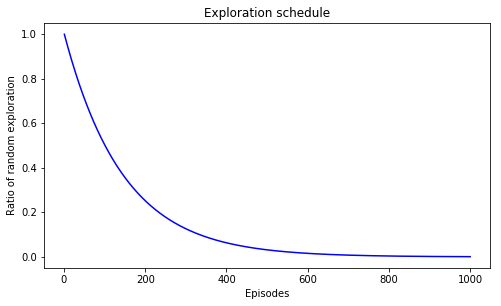

In [8]:
# Plotting exploration schedule
plt.figure(figsize=(8,4.5))
x_series = np.array(range(1,episodes+1))
y_series = epsilon_sequence[0:episodes]
plt.plot(x_series, y_series, '-b')
plt.xlabel('Episodes')
plt.ylabel('Ratio of random exploration')
plt.title('Exploration schedule')
plt.show()

In [9]:
if __name__ == "__main__":
    # Initialize storage
    reward_storage = []
    best_agent_weights = []
    best_agent_memory = []
    reward_plot = np.zeros([episodes,])
    loss_plot = np.zeros([episodes,])

    # Initialize simulation
    Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                memory_population_length, timesteps_per_second,\
                                                                delete_results = True, verbose = True)
        
    # Setting Random Seed
    Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
    print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

    # Deploy Network Parser (crawl network)
    npa = NetworkParser(Vissim)
    print('NetworkParser has succesfully crawled the model network.')
    
    # Initialize agents
    if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                           gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                           DoubleDQN = True if agent_type == "DDQN" or "DuelingDDQN" else False,\
                           Dueling = False if agent_type == "DQN" or "DDQN" else True) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    else:
        print("Incorrect Agent Class selected. Deployment could not be completed.")
        quit()
    if agents_deployed:
        print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))
    
    ## EXECUTION OF A DEMONSTRATION RUN (slow, choice of best available agent)
    if mode == "demo":
        timesteps_per_second = 10
        Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
        Agents = SF.load_agents(vissim_working_directory, model_name, Agents, Session_ID, best = True)
        for agent in Agents:
            agent.epsilon = 0
        SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, memory_population_length,\
                                  timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                  demand_list, demand_change_timesteps, mode, PER_activated)
        Vissim = None
    
    ## EXECUTION IN DEBUGGING MODE (slow, extra messages)
    elif mode == "debug":
        timesteps_per_second = 10
        Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
        SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, memory_population_length,\
                                  timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                  demand_list, demand_change_timesteps, mode, PER_activated)
        Vissim = None
        
    ## EXECUTION OF MEMORY POPULATION and creation of memory files
    elif mode == "populate":
        SF.Set_Quickmode(Vissim, timesteps_per_second)
        if PER_activated:
            memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                                vissim_working_directory, model_name, Session_ID,\
                                                                seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                                demand_list, demand_change_timesteps, PER_activated)
            print("PER memory prepopulated with {} entries".format(memory_size))
        Vissim = None
        
    ## EXECUTION OF TEST MODE (fast, best agents, more metrics out)    
    elif mode == "test":
        pass
    
    ## EXECUTION OF THE NORMAL TRAINING LOOP
    elif mode == "training":
        # Load previous memory if available, else create it
        SF.Set_Quickmode(Vissim, timesteps_per_second)
        memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                        vissim_working_directory, model_name, Session_ID,\
                                                        seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                        demand_list, demand_change_timesteps, PER_activated)
        print('Memory pre-populated. Starting Training.\n')
        
        # Iterations of the simulation
        for episode in log_progress(range(episodes), every=1):
        
            # Reload map if it has already been run (previous episode or prepopulation)
            if episode !=0 or runflag == True:
                Simulation, Network = COMServerReload(Vissim, model_name, vissim_working_directory,\
                                                      simulation_length, timesteps_per_second, delete_results = True)

                # Run Network Parser and ensure agents are linked to their intersections
                npa = NetworkParser(Vissim)
                for index, agent in enumerate(Agents):
                    agent.update_IDS(agent.signal_id, npa)
                    agent.episode_reward = []

            # Change the random seed
            Random_Seed += 1
            Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
                    
            # Run Episode at maximum speed
            SF.Set_Quickmode(Vissim, timesteps_per_second)
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length, timesteps_per_second,\
                                      seconds_per_green, seconds_per_yellow, demand_list, demand_change_timesteps, mode,\
                                      PER_activated)
        
            # Calculate episode average reward
            reward_storage, average_reward = SF.average_reward(reward_storage, Agents, episode, episodes)
            best_agent_weights, best_agent_memory = SF.best_agent(reward_storage, average_reward,\
                                                                  best_agent_weights, best_agent_memory,\
                                                                  vissim_working_directory, model_name, Agents, Session_ID)
        
            # Train agent with experience of episode and copy weights when necessary
            # Update exploration rate
            for agent in Agents:
                agent.learn_batch(batch_size, episode)
                agent.epsilon = epsilon_sequence[episode+1]
            
            # Security save for long trainings
            if SaveResultsAgent:
                if (episode+1)%partial_save_at == 0:
                    SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
                    print('Saved Partial results at the end of episode {}.'.format(episode+1))

        #Saving agents memory, weights and optimizer
        if SaveResultsAgent:
            SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
            print("Model, architecture, weights, optimizer, memory and training results succesfully saved.\
            Succesfully Terminated.")
    
    else:
        raise Exception("ERROR: Mode selected not recognized. TERMINATING.")
    # Close Vissim
    Vissim = None

Working Directory set to: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Loading Model File: Single_Cross_Straight.inpx ...
Load process successful
Simulation length set to 720001 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Simulation Object
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                 SETUP COMPLETE                      *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 42
NetworkParser has succesfully crawled the model network.
Deploying instance of Double Deep Q Learning Agent(s)
Deployed 1 agent(s) of the Clas

KeyboardInterrupt: 

In [36]:
# Plotting training progress
plt.figure(figsize=(8,4.5))
x_series = range(1,len(reward_storage)+1)
fit = np.polyfit(x_series,reward_storage,1)
fit_fn = np.poly1d(fit) 
plt.plot(x_series,reward_storage, '-b', x_series, fit_fn(x_series), '--r')
plt.xlabel('Episodes')
plt.ylabel('Average agent reward in episode')
plt.title('Training evolution and trend')
plt.gca().legend(('Episode Reward','Linear Trend'))
plt.show()

# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

TypeError: expected non-empty vector for x

<Figure size 576x324 with 0 Axes>

In [33]:
### SHORT PRETRAINED FROM MEMORY DEMO
# Initialize storage
reward_storage = []
best_agent_weights = []
best_agent_memory = []
reward_plot = np.zeros([episodes,])
loss_plot = np.zeros([episodes,])

# Initialize simulation
Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                            memory_population_length, timesteps_per_second,\
                                                            delete_results = True, verbose = True)

# Setting Random Seed
Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

# Deploy Network Parser (crawl network)
npa = NetworkParser(Vissim)
print('NetworkParser has succesfully crawled the model network.')

# Initialize agents
if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
    Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                       gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                       DoubleDQN = True if agent_type == "DDQN" or "DuelingDDQN" else False,\
                       Dueling = False if agent_type == "DQN" or "DDQN" else True) for ID in npa.signal_controllers_ids] 
    agents_deployed = True
else:
    print("Incorrect Agent Class selected. Deployment could not be completed.")
    quit()
if agents_deployed:
    print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))

    memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                        vissim_working_directory, model_name, Session_ID,\
                                                        seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                        demand_list, demand_change_timesteps, PER_activated)
print('Memory pre-populated. Starting Training.\n')

Working Directory set to: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Loading Model File: Single_Cross_Straight.inpx ...
Load process successful
Simulation length set to 720001 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Simulation Object
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                 SETUP COMPLETE                      *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 42
NetworkParser has succesfully crawled the model network.
Deploying instance of Double Deep Q Learning Agent(s)
Deployed 1 agent(s) of the Clas

In [37]:
for i in range(600):
    Agents[0].learn_batch(1024, 0)
    print("Prediction for [50,0,50,0] is: {}".format(Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))))

Prediction for [50,0,50,0] is: [[-96.21001 -93.7373 ]]
Prediction for [50,0,50,0] is: [[-88.19781 -91.48635]]
Prediction for [50,0,50,0] is: [[-95.69573 -98.98147]]
Prediction for [50,0,50,0] is: [[ -95.6585   -100.413124]]
Prediction for [50,0,50,0] is: [[-92.56124 -98.35698]]
Prediction for [50,0,50,0] is: [[-93.65682 -99.50793]]
Prediction for [50,0,50,0] is: [[ -98.91864 -103.29671]]
Prediction for [50,0,50,0] is: [[ -99.93705 -107.03251]]
Prediction for [50,0,50,0] is: [[-1.4952635 -1.5935124]]
Prediction for [50,0,50,0] is: [[-2.1193347 -2.200062 ]]
Prediction for [50,0,50,0] is: [[-2.6158724 -2.636978 ]]
Prediction for [50,0,50,0] is: [[-3.0373406 -3.0526803]]


KeyboardInterrupt: 

In [35]:
## EXECUTION OF A DEMONSTRATION RUN (slow, choice of best available agent)
timesteps_per_second = 10
Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
for agent in Agents:
    agent.epsilon = 0
SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, memory_population_length,\
                          timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                          demand_list, demand_change_timesteps, mode, PER_activated)
Vissim = None

Agent Reward in this cycle is : 0
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -3.84
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -5.26
Agent Reward in this cycle is : -6.95
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -9.06
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -6.15
Agent Reward in this cycle is : -4.34
Agent Reward in this cycle is : -17.11
Agent Reward in this cycle is : -24.0
Agent Reward in this cycle is : -23.9
Agent Reward in this cycle is : -23.9
Agent Reward in this cycle is : -37.41
Agent Reward in this cycle is : -16.82
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle is : -0.0
Agent Reward in this cycle

Agent Reward in this cycle is : -484.6
Agent Reward in this cycle is : -546.33
Agent Reward in this cycle is : -298.75
Agent Reward in this cycle is : -195.6
Agent Reward in this cycle is : -280.56
Agent Reward in this cycle is : -343.2
Agent Reward in this cycle is : -342.79
Agent Reward in this cycle is : -348.99
Agent Reward in this cycle is : -380.49
Agent Reward in this cycle is : -254.58
Agent Reward in this cycle is : -226.37
Agent Reward in this cycle is : -255.26
Agent Reward in this cycle is : -278.39
Agent Reward in this cycle is : -226.85
Agent Reward in this cycle is : -203.95
Agent Reward in this cycle is : -58.05
Agent Reward in this cycle is : -61.74
Agent Reward in this cycle is : -51.76
Agent Reward in this cycle is : -67.37
Agent Reward in this cycle is : -88.1
Agent Reward in this cycle is : -37.76
Agent Reward in this cycle is : -5.02
Agent Reward in this cycle is : -19.6
Agent Reward in this cycle is : -24.94
Agent Reward in this cycle is : -27.35
Agent Reward in 

com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147467259), None)

In [ ]:
print(Agents[0].state)
print(Agents[0].action)
print(Agents[0].reward)
print(Agents[0].newstate)
print(Agents[0].newaction)

In [13]:
 Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                       gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                       DoubleDQN = True if agent_type == "DDQN" or "DuelingDDQN" else False,\
                       Dueling = False if agent_type == "DQN" or "DDQN" else True) for ID in npa.signal_controllers_ids] 

Deploying instance of Double Deep Q Learning Agent(s)


In [ ]:
Memory_Filename = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID, model_name+ '_Agent'+str(index)+'_Memory'+'.p')
a = pickle.load(open(Memory_Filename, 'rb'))

In [ ]:
current_queue_sum = np.sum([0 if state is None else state for state in Agents[0].newstate[0]])
current_queue_sum**2

In [ ]:
np.sum(np.array([0 if state is None else state for state in Agents[0].newstate[0]])**2)

In [ ]:
for agent in Agents:
    memory = pickle.load(open(prepopulation_filename, 'rb'))
    for s,a,r,s_ in memory:
        agent.remember(s,a,r,s_)
        # FCalculate importance sampling weights
    update_priority_weights(agent, memory_size)
    # No simulation ran

In [28]:
Agents[0].model.predict(np.reshape([3,0,3,0], [1,4]))

array([[-12.045227, -11.181825]], dtype=float32)